This is for plotting mean wind profile under neutral condition.\
Note: 1. data with diag_csat_ins >= 65 are discarded in advance.\
2. B1 (the 4th level) uses different CSAT model

2022-3-30

In [1]:
# This jupyter notebook command inserts matplotlib graphics in 
# to the workbook
%matplotlib inline

# import packages
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os.path
import pickle
import time
from matplotlib.pyplot import figure
import scipy.io as sio
from datetime import date, timedelta
from math import *
from scipy.stats import gmean
from scipy import ndimage
from scipy import stats
from matplotlib.ticker import MaxNLocator
import seaborn as sns

# directories
IN_DIRECTORY = "/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/basic_processed_data/"
IN_DIRECTORY2 = "/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/processed_data/"
msk_DIR = "/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/mask_data/"
OUT_DIRECTORY = "/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/neutral_data_20200925_20210423/"
PLOT_DIRECTORY = "/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/fig_neutral/"
ins_var=['u_ins3d','v_ins3d'] # 36000 instantaneous variables per hour 
tur_var=['u_tur3d','v_tur3d','w_tur3d'] # 36000 instantaneous variables per hour
avg_var=['u_avg','u_star','L_H2','v_avg','w_avg','u_std','v_std','w_std','T_avg','rot_ang_v'] # 1 averaged variable per hour
flg_var=['diag_csat_ins','sig_irga_ins']
msk = ['mask_INL_all_1d']
out_var=['neutral_case','u_star_mean','temp_stability','kappa_m2',
         'kappa_m2_stability_corrected','u_star_dev','u_star_m1_sel_dev',
         'u_star_m1_dev','u_star_m1_sel','u_star_m1','u_star_fit','u_star_m2',
         'zo_m1','zo_m1_sel','u_avg_neutral','v_avg_neutral','w_avg_neutral',
         'u_star_m1_dev_abs_mean','u_star_m1_sel_dev_abs_mean','u_star_m2_dev_abs_mean',
         'u_std_neutral','v_std_neutral','w_std_neutral',
         'ist_before','r2_m1','r2_m1_sel','r2_m2',
         'u_star_m2_dif','wind_ang_neutral','wind_diff_max_neutral','u_star_neutral',
         'kappa_m2_ec_mean','u_star_dif_mean','wdir_neutral',
         'r2_A1_ec_mean','r2_A1_m1']

## Define constants and labels ##

In [2]:
# EC settings
sonum    =12                       # number of sonic
z        = np.array([1.2,2,3.5,6,8.2,12.8,15.8,23,30.3,40.2,50.6,60.5])                # height of sonic above ground, m
frequency=10                   # sampling frequency, Hz
time_avg =3600                  # average time, s
rpat = time_avg*frequency           # number of lines for a loop

# physical constants (or values that are assumed constant)
Rw  = 461.5     # ideal gas constant for water vapor, J/kg*K
Rd  = 287.05    # ideal gas constant for dry air, J/kg*K
Lv  = 1000*2257 # latent heat of vaporization (water), J/kg
Cp  = 1005      # approximate constant pressure specific heat of air, J/kg*K
kappa   = 0.4       # Von Karman constant
g   = 9.81      # acceleration of gravity, m/s^2
list_col = ['C1','C2','C3','C4','B1','B2','B3','B4','A1','A2','A3','A4']

# selected levels
# list_sel = range(5,11) # from level 6 to level 11
list_sel_m1 = np.array([5,6,7,8,9,10]) # from level 6 to level 11
list_sel_m2 = np.array([5,6,7,8,9,10])
# list_all = np.array([0,1,2,3,6,7,8,9,10,11])
xtick_labels = ["1.2","2","3.5","6","8.2","12.8","15.8","23","30.3","40.2","50.6","60.5"]

load_tur_after_dtr_rot = True
load_tur_before_dtr = True
save_tur = False

## Define functions ##

In [3]:
def date_list(sdate,edate):
    """method used for creating date list"""
    delta = edate - sdate       # as timedelta
    day = [sdate+timedelta(days=x) for x in range(delta.days+1)]
    return day

def wind_ang(u,v):
    """
    method used for computing wind angle based on u and v velocity
    assume the CSAT3 (the anemometer arms, tripods) is aligned northward 
    and if u is positive, the wind is northerly. 
    If v is positive, the wind is westerly.
    u:north(+)->south(-), v:west(+)->east(-)
    """
    rot_ang_v = np.arctan(v/u);
    rot_ang_v = np.degrees(rot_ang_v)
    mask1 = np.logical_and(u>=0, v<=0)
    rot_ang_v[mask1] = -rot_ang_v[mask1] # northeast
    mask2 = np.logical_and(u<=0, v<=0)
    rot_ang_v[mask2] = 180-rot_ang_v[mask2] # southest
    mask3 = np.logical_and(u<=0, v>=0)
    rot_ang_v[mask3] = 180-rot_ang_v[mask3] # southwest
    mask4 = np.logical_and(u>=0, v>=0)
    rot_ang_v[mask4] = 360-rot_ang_v[mask4] # northwest
    return rot_ang_v

def convert_ang(wdir):
    wdir_new = wdir
    wdir_new[wdir>180] = wdir_new[wdir>180] - 360
    wdir_new[wdir<-180] = wdir_new[wdir<-180] + 360
    return wdir_new

# Load instantaneous data and process data #

In [ ]:
%%time
# set up time period and initialize variables
Sdate = date(2020,9,25)
# Edate = date(2020,9,27)
Edate = date(2021,4,23)
ds = date_list(Sdate,Edate)
u_star_mean = []
slope_m1, slope_m1_sel, slope_m2 = [],[],[]
intecept_m1, intecept_m1_sel, intecept_m2 = [],[],[]
zo_m1, zo_m1_sel, zo_m2 = [],[],[]
u_star_m1, u_star_m1_sel,u_star_fit, u_star_m2 = [],[],[],[]
u_star_neutral,u_star_dev = [],[] # 2d
u_star_m1_dev,u_star_m1_sel_dev,u_star_m2_dev = [],[],[] # 2d
u_star_m1_dev_abs_mean,u_star_m1_sel_dev_abs_mean,u_star_m2_dev_abs_mean = [],[],[]
kappa_m2,kappa_m2_ec_mean = [],[] # 1d
neutral_case = [] # list of the occurrence of the neutral cases
u_avg_neutral,v_avg_neutral,w_avg_neutral = [],[],[] # 2d
u_std_neutral,v_std_neutral,w_std_neutral = [],[],[] # 2d
T_avg_neutral,rot_ang_v_neutral = [],[] # 2d
temp_stability = [] # 1d
kappa_m2_stability_corrected = [] # 1d
zo_m2_stability_corrected = [] # 1d
ist_before0,ist_after0 = np.empty(sonum)*np.nan,np.empty(sonum)*np.nan
ist_before,ist_after = [],[]
r2_m1,r2_m1_sel,r2_m2 = [],[],[]
u_star_m1_dif,u_star_m2_dif,u_star_dif_mean = [],[],[]
# wind_ang_neutral,wind_ang_std = [],[] # 1d
wind_diff_max_neutral,wdir_neutral = [],[] # 2d
for day in ds:
    strday = str(day.strftime("%Y%m%d"))
    fp_stats = IN_DIRECTORY + 'u_ins_' + strday +'.pkl'
    if (not os.path.isfile(fp_stats)):
        print(day.strftime("%Y%m%d")+' do not exist')
        continue
    # print('start loading:'+ strday)
    
    # load neutral mask
    b_file = open(msk_DIR + 'mask_neutral_' + strday +'.pkl', "rb")
    mask_neutral = pickle.load(b_file)    
    b_file.close()
    if not any(mask_neutral):
        continue
    # load masks
    for var in msk:
        a_file = open(msk_DIR + var +'_' + strday +'.pkl', "rb")
        globals()[var] = pickle.load(a_file)    
        a_file.close()
    nan_msk=np.isnan(mask_INL_all_1d)
    if all(nan_msk):
        continue
        
    # load avg variables
    for var in avg_var: 
        a_file = open(IN_DIRECTORY + var +'_' + strday +'.pkl', "rb")
        globals()[var] = pickle.load(a_file)    
        a_file.close() 
    
    if load_tur_after_dtr_rot:
        # load tur variables after detrending and double rotation
        for var in tur_var: 
            a_file = open(IN_DIRECTORY + var +'_' + strday +'.pkl', "rb")
            globals()[var] = pickle.load(a_file)    
            a_file.close()
            
    if load_tur_before_dtr:
        # load tur variables after detrending and double rotation
        for var in ins_var: 
            a_file = open(IN_DIRECTORY + var +'_before_dtr_' + strday +'.pkl', "rb")
            globals()[var+'_before_dtr'] = pickle.load(a_file)    
            a_file.close()
    
    # ---------------- compute log wind profile
    print('start processing:'+ strday)       
    for i in range(24): # loop of hour
        if mask_neutral[i] and (~nan_msk[i]):
            print('neutral case - Hour ' + str(i+1))
            u_star_neutral = np.append(u_star_neutral, u_star[i,:])
            neutral_case.append([day,i+1]) # time index of neutral cases
            
            u_avg_neutral = np.append(u_avg_neutral, u_avg[i,:])
            v_avg_neutral = np.append(v_avg_neutral, v_avg[i,:])
            w_avg_neutral = np.append(w_avg_neutral, w_avg[i,:])
            u_std_neutral = np.append(u_std_neutral, u_std[i,:])
            v_std_neutral = np.append(v_std_neutral, v_std[i,:])
            w_std_neutral = np.append(w_std_neutral, w_std[i,:])
            
            # !compute variations of u_star{ec} across vertical levels, 
            # !the mean value is calculated by selected levels
            u_star_mean0 = np.nanmean(u_star[i,list_sel_m1])
            u_star_mean = np.append(u_star_mean, u_star_mean0) # mean of the selected level
            u_star_dev = np.append(u_star_dev, (u_star[i,:]-u_star_mean0)/u_star_mean0, axis=0)

            # !compute u_star by method 1, fit with kappa = 0.4 and using all level data
            mask1 = ~np.isnan(z)
            mask2 = ~np.isnan(u_avg[i,:])
            mask = mask1 & mask2 # mask out nan values
            p1,p2,r_m1,_,_ = stats.linregress(np.log(z[mask]), u_avg[i,mask])
            r2_m1 = np.append(r2_m1,r_m1**2)
            # p1,p2 = np.polyfit(np.log(z[mask]), u_avg[i,mask], deg = 1)
            # print(res.slope-p1)
            # print(res.intercept-p2)
            slope_m1 = np.append(slope_m1, p1)
            intecept_m1 = np.append(intecept_m1,p2)
            zo_m1 = np.append(zo_m1,exp(-p2/p1)) # momentum roughness length           

            u_star_m1_0 = kappa*p1
            u_star_m1 = np.append(u_star_m1,u_star_m1_0)

            # compute variations of u_star across all levels, 
            # the mean value is calculated by method 1 using all level
            u_star_m1_dev0 = (u_star[i,:]-u_star_m1_0)/u_star_m1_0
            u_star_m1_dev = np.append(u_star_m1_dev, u_star_m1_dev0, axis=0)  
            # mean absolute error of u_star to u_star_m1
            u_star_m1_dev_abs_mean = np.append(u_star_m1_dev_abs_mean, 
                                               np.nanmean(abs(u_star_m1_dev0[:])))

            # !compute u_star by method 1, fit with kappa = 0.4 and using selected level data
            p3,p4,r_m1_sel,_,_ = stats.linregress(np.log(z[list_sel_m1]), u_avg[i,list_sel_m1])
            r2_m1_sel = np.append(r2_m1_sel,r_m1_sel**2)
            # p3,p4 = np.polyfit(np.log(z[list_sel_m1]), u_avg[i,list_sel_m1], deg = 1)
            slope_m1_sel = np.append(slope_m1_sel, p3)
            intecept_m1_sel = np.append(intecept_m1_sel,p4)
            zo_m1_sel = np.append(zo_m1_sel,exp(-p4/p3)) # momentum roughness length

            u_star_m1_sel0 = kappa*p3
            u_star_m1_sel = np.append(u_star_m1_sel,u_star_m1_sel0)

            # compute variations of u_star across all levels
            # the mean value is calculated by method 1 using selected level
            u_star_m1_sel_dev0 = (u_star[i,:]-u_star_m1_sel0)/u_star_m1_sel0
            u_star_m1_sel_dev = np.append(u_star_m1_sel_dev, u_star_m1_sel_dev0, axis=0)  
            # mean absolute error of u_star to u_star_m1_sel
            u_star_m1_sel_dev_abs_mean = np.append(u_star_m1_sel_dev_abs_mean, 
                                                   np.nanmean(abs(u_star_m1_sel_dev0[list_sel_m1])))
            print('finish:m1 fitting')
            
            #! method2, fit with ec measured ustar and using selected data
            # This method will give nearly the same zo as method 1 if using
            # the same selected data, the only difference is the kappa value and the u_star
            # 1. u_star is calculated by linearly interpolate to the ground level
            p_u_1,p_u_2 = np.polyfit(z[list_sel_m2], u_star[i,list_sel_m2], deg = 1)
            u_star_fit = np.append(u_star_fit, p_u_2)

            # 2. fit the log wind profile
            p5,p6,r_m2,_,_ = stats.linregress(np.log(z[list_sel_m2]), u_avg[i,list_sel_m2])
            r2_m2 = np.append(r2_m2,r_m2**2)
            # p5,p6 = np.polyfit(np.log(z[list_sel_m2]), u_avg[i,list_sel_m2], deg = 1)
            slope_m2 = np.append(slope_m2, p5)
            intecept_m2_sel = np.append(intecept_m2,p6)
            zo_m2 = np.append(zo_m2,exp(-p6/p5)) # momentum roughness length
            # u_star_m2 is same as u_star_mean
            # list_sel_m2 = list_sel_m1
            u_star_m2_0 = np.nanmean(u_star[i,list_sel_m2])
            u_star_m2 = np.append(u_star_m2,u_star_m2_0)
            kappa_m2_0 = p_u_2/p5
            kappa_m2 = np.append(kappa_m2, kappa_m2_0)  
            
            kappa_m2_ec_mean0 = u_star_mean0/p5
            kappa_m2_ec_mean = np.append(kappa_m2_ec_mean, kappa_m2_ec_mean0)
            
            # stability parameter
            temp_stability0 = gmean(z[list_sel_m2])/ndimage.median(L_H2[i,list_sel_m2])
            temp_stability = np.append(temp_stability,temp_stability0)
            if temp_stability0 >0: # stable condition
                k_cor = kappa_m2_0*(1+5*temp_stability0)
                kappa_m2_stability_corrected = np.append(kappa_m2_stability_corrected,k_cor)
            else: # unstable condition
                k_cor = kappa_m2_0*(1-16*temp_stability0)**(-1/4)
                kappa_m2_stability_corrected = np.append(kappa_m2_stability_corrected,k_cor)
            # stability corrected roughness length
            zo_cor = exp(-p6/(p_u_2/k_cor))  # !This needs to be revisited
            zo_m2_stability_corrected = np.append(zo_m2_stability_corrected, zo_cor)

            u_star_m2_dev0 = (u_star[i,:]-p_u_2)/p_u_2
            u_star_m2_dev = np.append(u_star_m2_dev, u_star_m2_dev0, axis=0)                
            u_star_m2_dev_abs_mean = np.append(u_star_m2_dev_abs_mean, 
                                               np.nanmean(abs(u_star_m2_dev0[:])))
            # difference between max(u_star) and min(u_star)
            u_star_dif = (np.nanmax(u_star[i,list_sel_m2])-np.nanmin(u_star[i,list_sel_m2]))/np.nanmin(u_star[i,list_sel_m2])
            u_star_m2_dif = np.append(u_star_m2_dif,u_star_dif)
            
             # max difference between u_star and u_star_mean
            u_star_dif_mean0 = np.nanmax(u_star[i,list_sel_m2]-u_star_mean0)/u_star_mean0
            u_star_dif_mean = np.append(u_star_dif_mean,u_star_dif_mean0)
            
            print('finish:m2 fitting')
            
            # The following needs turbulence data
            if load_tur_after_dtr_rot and load_tur_before_dtr:
                u_tur= u_tur3d[i,:,:]
                v_tur= v_tur3d[i,:,:]
                w_tur= w_tur3d[i,:,:]
                # non-stationarity index
                for j in list_sel_m2: # for selected level only
                    u_tur_temp = u_tur[:,j].reshape([12,-1]) # split each hour into 12 chunks/every 5 min
                    cvm = np.nanmean(np.nanvar(u_tur_temp,axis=1)) # avg of the variance of each chunck
                    ist_before0[j] = abs(cvm-np.nanvar(u_tur[:,j]))/np.nanvar(u_tur[:,j])
                # print(ist_before0)
                ist_before = np.append(ist_before, ist_before0)
                print('finish:IST')

                # Deviation of the wind angle from the hourly mean
                u_ins_before_dtr= u_ins3d_before_dtr[i,:,:]
                v_ins_before_dtr= v_ins3d_before_dtr[i,:,:]
                
                # convert wind direction to [-180,180]
                wind_ang_1hr = convert_ang(rot_ang_v[i,:])
                wdir_neutral = np.append(wdir_neutral,wind_ang_1hr)
                wdir_diff_max = np.empty(12)*np.nan
                for j in list_sel_m2: # for selected levels only
                    u_ins_5min = u_ins_before_dtr[:,j].reshape([12,-1]) # split each hour into 12 chunks/every 5 min
                    v_ins_5min = v_ins_before_dtr[:,j].reshape([12,-1])
                    u_avg_5min = np.nanmean(u_ins_5min, axis=1) # 12 averaged numbers 
                    v_avg_5min = np.nanmean(v_ins_5min, axis=1)
                    # calculate wind angle
                    wind_ang_temp = wind_ang(u_avg_5min,v_avg_5min)
                    # print(wind_ang_temp, end='\n')
                    wind_ang_5min = convert_ang(wind_ang_temp) # 5min wind direction for one single level
                    # print(wind_ang_5min, end='\n')
                    # abs difference between the 5min wdir and 1hr wdir
                    diff_temp = abs(wind_ang_5min-wind_ang_1hr[j]) 
                    # print(diff_temp)
                    wdir_diff_max[j] = np.nanmax(diff_temp)
                wind_diff_max_neutral = np.append(wind_diff_max_neutral,wdir_diff_max)
                print('finish:wind direction')
            
            # save turbulence under neutral conditions
            if save_tur:
                for var in ['u_tur','v_tur','w_tur','wind_ang']:
                    a_file = open(OUT_DIRECTORY + var + '_' + strday +'_'+str(i+1)+'.pkl', "wb")
                    pickle.dump(eval(var), a_file)
                    a_file.close()

    print('finish processing:'+ strday)
    print('------------------------')

## !Remember to reshape 2D variables ##

u_star_dev = np.reshape(u_star_dev,(-1,12))
u_star_m1_dev = np.reshape(u_star_m1_dev,(-1,12))
u_star_m1_sel_dev = np.reshape(u_star_m1_sel_dev,(-1,12))
u_star_m2_dev = np.reshape(u_star_m2_dev,(-1,12))
u_avg_neutral = np.reshape(u_avg_neutral,(-1,12))
v_avg_neutral = np.reshape(v_avg_neutral,(-1,12))
w_avg_neutral = np.reshape(w_avg_neutral,(-1,12))
u_std_neutral = np.reshape(u_std_neutral,(-1,12))
v_std_neutral = np.reshape(v_std_neutral,(-1,12))
w_std_neutral = np.reshape(w_std_neutral,(-1,12))
ist_before = np.reshape(ist_before,(-1,12))
wind_diff_max_neutral = np.reshape(wind_diff_max_neutral,(-1,12))
u_star_neutral = np.reshape(u_star_neutral,(-1,12))
wdir_neutral = np.reshape(wdir_neutral,(-1,12))

# Save neutral data #
neutral_case,u_star_mean,temp_stability,kappa_m2,kappa_m2_stability_corrected,u_star_dev,u_star_m1_sel_dev,u_star_m1_dev,u_star_m1_sel,u_star_m1,u_star_m2,zo_m1,zo_m1_sel

In [ ]:
for var in ['u_star_dif_mean','wdir_neutral']:
    a_file = open(OUT_DIRECTORY + var + '.pkl', "wb")
    pickle.dump(eval(var), a_file)
    a_file.close()

# Load neutral data #

In [4]:
for var in out_var:
    a_file = open(OUT_DIRECTORY + var +'.pkl', "rb")
    globals()[var] = pickle.load(a_file)
    a_file.close()

In [6]:
%whos ndarray list 

Variable                       Type       Data/Info
---------------------------------------------------
avg_var                        list       n=10
flg_var                        list       n=2
ins_var                        list       n=2
ist_before                     ndarray    71x12: 852 elems, type `float64`, 6816 bytes
kappa_m2                       ndarray    71: 71 elems, type `float64`, 568 bytes
kappa_m2_ec_mean               ndarray    71: 71 elems, type `float64`, 568 bytes
kappa_m2_stability_corrected   ndarray    71: 71 elems, type `float64`, 568 bytes
list_col                       list       n=12
list_sel_m1                    ndarray    6: 6 elems, type `int64`, 48 bytes
list_sel_m2                    ndarray    6: 6 elems, type `int64`, 48 bytes
msk                            list       n=1
msk1                           ndarray    71: 71 elems, type `bool`, 71 bytes
neutral_case                   list       n=71
out_var                        list       n=36
r2_A1

# Let's start plotting ##

In [6]:
## PLOTTING STUFF
## define useful fonts
plt.rc('text', usetex=True)
# plt.rc('font', family='sans-serif')
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.weight"] = "bold"
plt.rc('xtick', labelsize=13) 
plt.rc('ytick', labelsize=13)
font_size = 14

## Kappa vs R2 ##

In [ ]:
y_plus = abs(kappa_m2_ec_mean-0.41)/0.41
msk = r2_m2>0.85
fig = plt.figure(figsize=(10,4), dpi=150,tight_layout=True)
ax1 = fig.add_subplot(121)
plt.plot(r2_m2,y_plus,'o',color = 'k',markerfacecolor='none')
# plt.axhline(y=y_mean, color='grey', linestyle='--', linewidth=1)
plt.xlabel(r'$R^2$', fontsize=font_size)
plt.ylabel(r'$|\kappa-0.41|/0.41$', fontsize=font_size)
# linear regression
slope, intercept,r,_,_ = stats.linregress(r2_m2, y_plus)
x = np.sort(r2_m2)
line = slope*x+intercept
plt.plot(x, line, 'k', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.legend(fontsize=12)
plt.title(r'Total\# = {:}'.format(len(y_plus)))
plt.plot(r2_m2[~msk],y_plus[~msk],'o',color = 'red',markerfacecolor='none')
plt.ylim(-0.1,3)


ax2 = fig.add_subplot(122)
plt.plot(r2_m2[msk],y_plus[msk],'o',color = 'k',markerfacecolor='none')
# plt.axhline(y=y_mean, color='grey', linestyle='--', linewidth=1)
plt.xlabel(r'$R^2$', fontsize=font_size)
plt.ylabel(r'$|\kappa-0.41|/0.41$', fontsize=font_size)
# linear regression
slope, intercept,r,_,_ = stats.linregress(r2_m2[msk], y_plus[msk])
x = np.sort(r2_m2[msk])
line = slope*x+intercept
plt.plot(x, line, 'k', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.legend(fontsize=12)
plt.title(r'Total\# = {:}'.format(len(y_plus[msk])))
plt.ylim(-0.1,3)
plt.savefig(PLOT_DIRECTORY + 'k_r2.jpg', dpi=200)

## ustar vs ustd ##

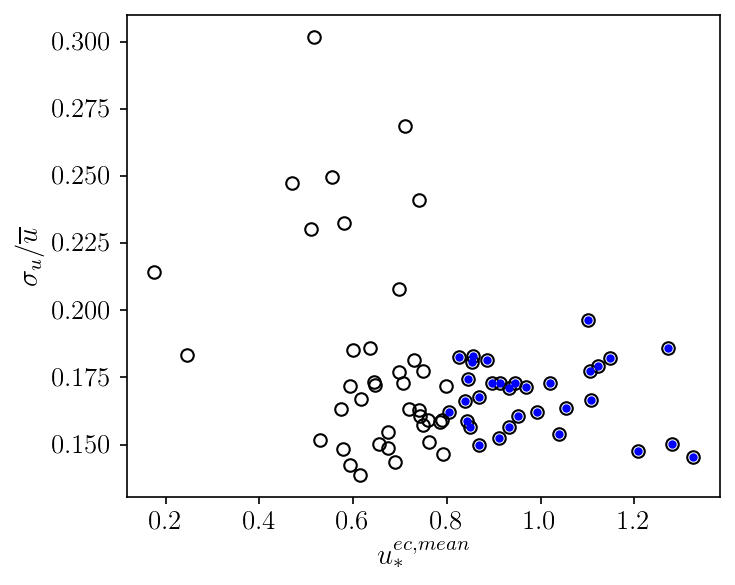

In [45]:
msk1 = u_star_mean>0.8
fig = plt.figure(figsize=(5,4), dpi=150,tight_layout=True)
ax1 = fig.add_subplot(111) 
plt.plot(u_star_mean,u_std_neutral[:,6]/u_avg_neutral[:,6],'o',color='black',markerfacecolor='none')
plt.plot(u_star_mean[msk1],(u_std_neutral[:,6]/u_avg_neutral[:,6])[msk1],'.',color='blue')
plt.xlabel(r'$u_*^{ec,mean}$', fontsize=font_size)
plt.ylabel(r'$\sigma_{u}/\overline{u}$', fontsize=font_size)

plt.savefig(PLOT_DIRECTORY + 'u_star_mean_u_std_15m.jpg', dpi=200)

Text(0, 0.5, '$\\sigma_{u}/\\overline{u}$')

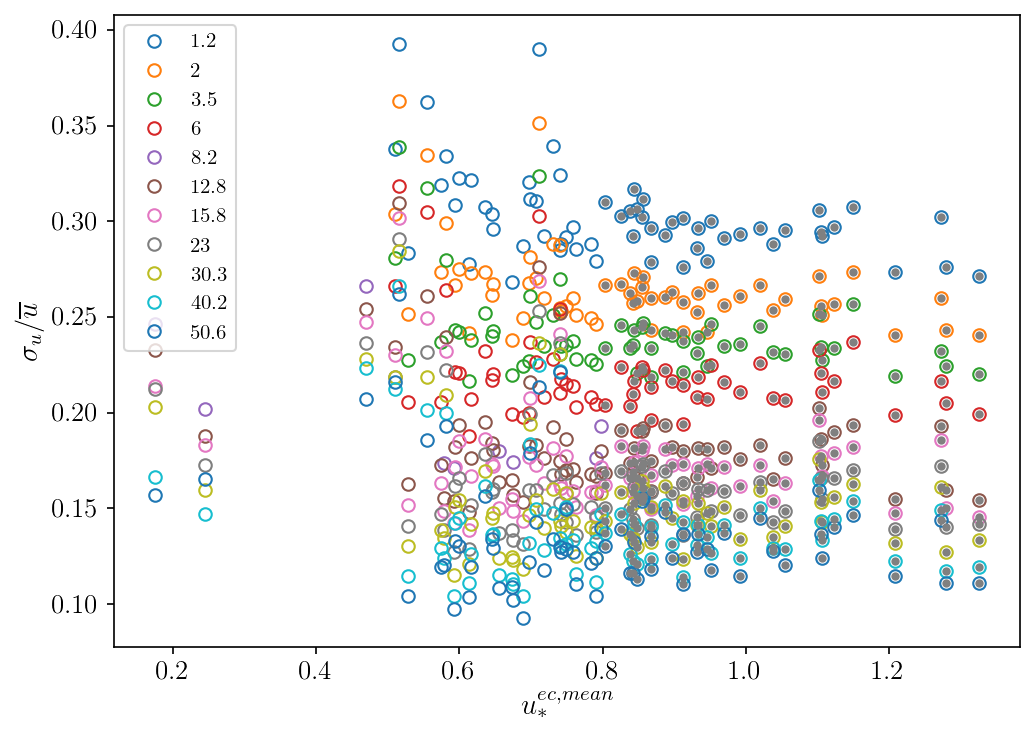

In [14]:
msk1 = u_star_mean>0.8
fig = plt.figure(figsize=(7,5), dpi=150,tight_layout=True)
ax1 = fig.add_subplot(111) 
for i in range(11):
    plt.plot(u_star_mean,u_std_neutral[:,i]/u_avg_neutral[:,i],'o',markerfacecolor='none')
plt.legend(xtick_labels)
for i in range(11):
    plt.plot(u_star_mean[msk1],(u_std_neutral[:,i]/u_avg_neutral[:,i])[msk1],'.',color='grey')
plt.xlabel(r'$u_*^{ec,mean}$', fontsize=font_size)
plt.ylabel(r'$\sigma_{u}/\overline{u}$', fontsize=font_size)

## occurence of the neutral cases ##

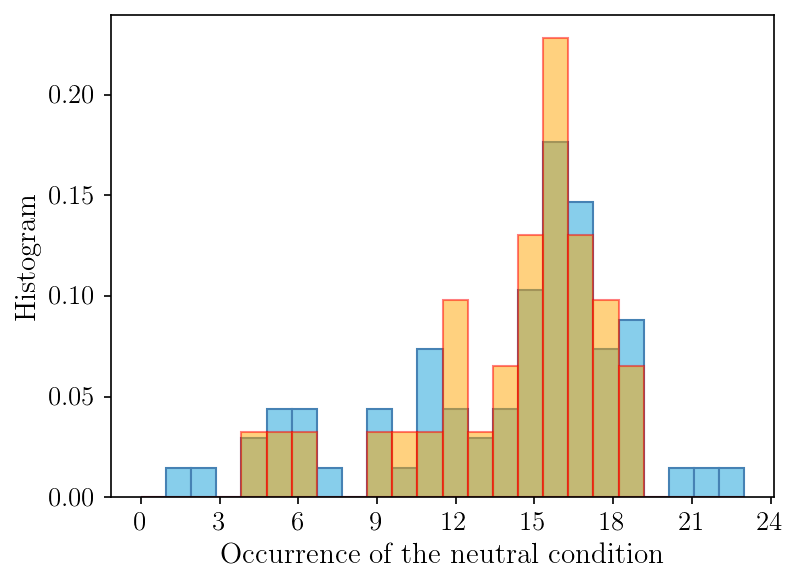

In [95]:
fig = plt.figure(figsize=(10, 4), dpi=150,tight_layout=True)
ax1 = fig.add_subplot(121)
n1, bins1, patches1 = plt.hist(np.array(neutral_case)[:,1], density=True, facecolor = "skyblue",edgecolor="steelblue",
                               range=(0,23),bins=24)  # arguments are passed to np.histogram
# ax1.plot(bins[0:20],n)
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
# plt.title(r'Total\# = {:}'.format(len(msk1)))
ax1.set_xlabel(r'\rm Occurrence of the neutral condition', fontsize = font_size)
ax1.set_ylabel(r'\rm Histogram', fontsize = font_size)

# ax2 = fig.add_subplot(122)
n2, bins2, patches2 = plt.hist(np.array(neutral_case)[msk1,1],density= True, facecolor = "orange",edgecolor="red",
                               range=(0,23),bins=24, alpha=0.5)  # arguments are passed to np.histogram
# ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
# plt.title(r'Total\# = {:}'.format(np.sum(msk1)))
# ax2.set_xlabel(r'\rm Occurrence of the neutral condition', fontsize = font_size)
# ax2.set_ylabel(r'\rm Histogram', fontsize = font_size)
# plt.savefig(PLOT_DIRECTORY + 'neutral_hour_hist.jpg', dpi=200)

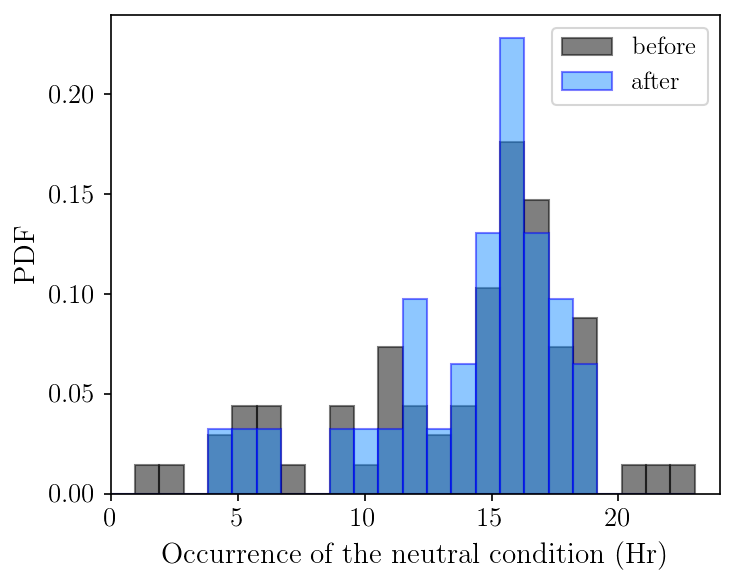

In [120]:
fig = plt.figure(figsize=(5, 4), dpi=150,tight_layout=True)
ax1 = fig.add_subplot(111)
sns.distplot(np.array(neutral_case)[:,1], hist=True, kde=True,
             bins=24, color = 'black', 
             hist_kws={'edgecolor':'black',"range": [0,23],'alpha':0.5},
             kde_kws={'linewidth': 0},
             label = 'before')
sns.distplot(np.array(neutral_case)[msk1,1], hist=True, kde=True, 
             bins=24, color = 'dodgerblue', 
             hist_kws={'edgecolor':'blue',"range": [0,23],'alpha':0.5},
             kde_kws={'linewidth': 0},
             label='after')
plt.xlim(0,24)
ax1.set_xlabel(r'\rm Occurrence of the neutral condition (Hr)', fontsize = font_size)
ax1.set_ylabel(r'\rm PDF', fontsize = font_size)
plt.legend(fontsize=12)
plt.savefig(PLOT_DIRECTORY + 'neutral_hour_hist.jpg', dpi=200)

## ustar vs IST, wdir change ##

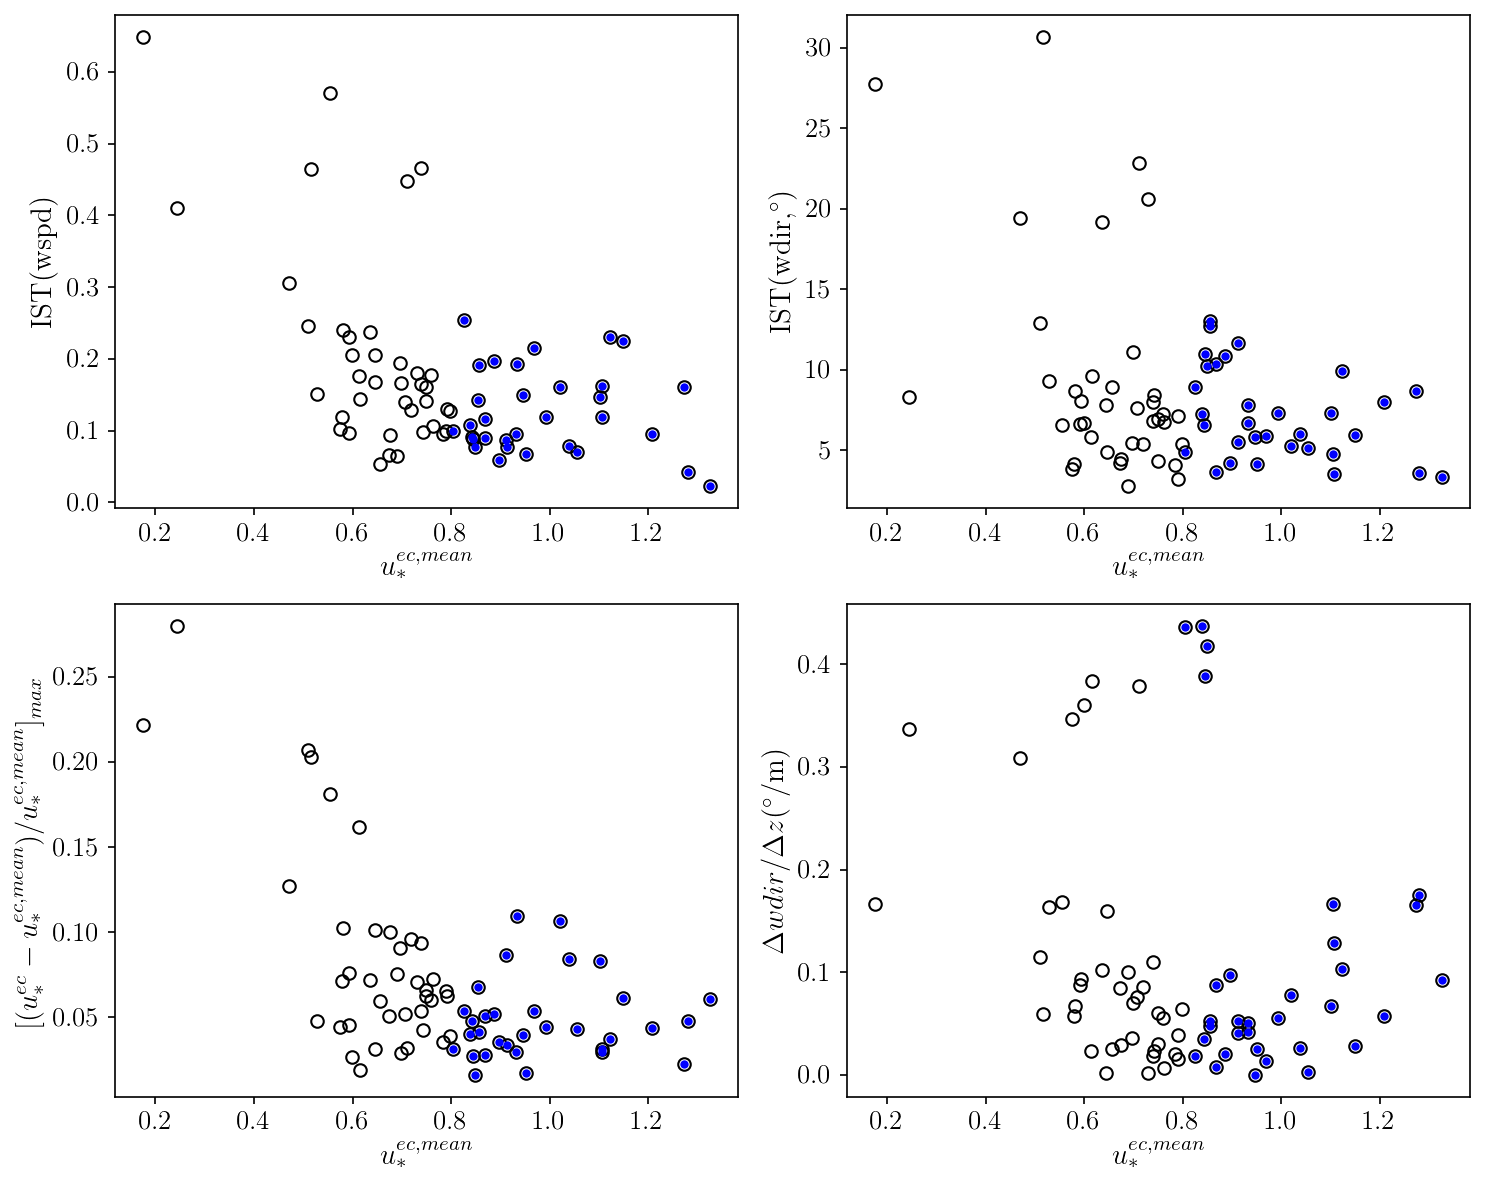

In [8]:
ist = ist_before[:,6]
ist_wdir = wind_diff_max_neutral[:,6]
dwdir_dh = (abs(np.diff(wdir_neutral[:,list_sel_m2],axis=1))/np.diff(z[list_sel_m2]))[:,1]
msk = r2_m2>0.85
msk1 = np.logical_and(msk,u_star_mean>0.8)
fig = plt.figure(figsize=(10,8), dpi=150,tight_layout=True)
ax1 = fig.add_subplot(221) 
plt.plot(u_star_mean,ist,'o',color = 'k',markerfacecolor='none')
plt.plot(u_star_mean[msk1],ist[msk1],'.',color='blue')
plt.xlabel(r'$u_*^{ec,mean}$', fontsize=font_size)
plt.ylabel(r'IST(wspd)', fontsize=font_size)

ax2 = fig.add_subplot(222) 
plt.plot(u_star_mean,ist_wdir,'o',color = 'k',markerfacecolor='none')
plt.plot(u_star_mean[msk1],ist_wdir[msk1],'.',color='blue')
plt.xlabel(r'$u_*^{ec,mean}$', fontsize=font_size)
plt.ylabel(r'IST(wdir,$^\circ$)', fontsize=font_size)

ax3 = fig.add_subplot(223) 
plt.plot(u_star_mean,u_star_dif_mean,'o',color = 'k',markerfacecolor='none')
plt.plot(u_star_mean[msk1],u_star_dif_mean[msk1],'.',color='blue')
plt.xlabel(r'$u_*^{ec,mean}$', fontsize=font_size)
plt.ylabel(r'$[(u_*^{ec}-u_*^{ec,mean})/u_*^{ec,mean}]_{max}$', fontsize=font_size)

ax4 = fig.add_subplot(224) 
plt.plot(u_star_mean,dwdir_dh,'o',color = 'k',markerfacecolor='none')
plt.plot(u_star_mean[msk1],dwdir_dh[msk1],'.',color='blue')
plt.xlabel(r'$u_*^{ec,mean}$', fontsize=font_size)
plt.ylabel(r'$\Delta wdir/\Delta z$($^\circ$/m)', fontsize=font_size)
plt.savefig(PLOT_DIRECTORY + 'ustar_ist_wdir.jpg', dpi=200)

## ustar vs kappa ##

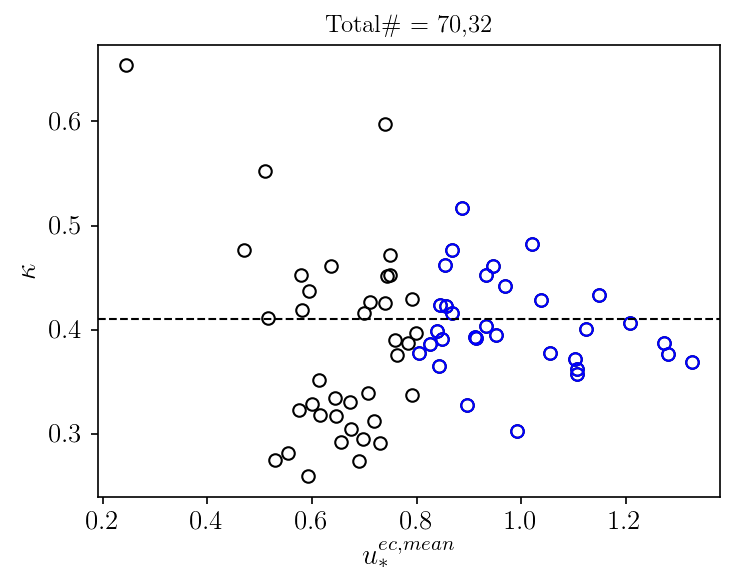

In [50]:
y_temp = kappa_m2_ec_mean
msk = r2_m2>0.85
msk1 = np.logical_and(msk,u_star_mean>0.8)
fig = plt.figure(figsize=(5,4), dpi=150,tight_layout=True)
ax1 = fig.add_subplot(111)
plt.plot(u_star_mean[msk],y_temp[msk],'o',color = 'k',markerfacecolor='none')
plt.xlabel(r'$u_*^{ec,mean}$', fontsize=font_size)
plt.ylabel(r'$\kappa$', fontsize=font_size)
ax1.plot(u_star_mean[msk1],y_temp[msk1],'o',color = 'blue',markerfacecolor='none')
plt.axhline(y=0.41, color='k', linestyle='--', linewidth=1)

# y_temp = abs(kappa_m2_ec_mean-0.41)/0.41
# ax3 = fig.add_subplot(122)
# plt.plot(u_star_mean[msk],y_temp[msk],'o',color = 'k',markerfacecolor='none')
# plt.xlabel(r'$u_*^{ec,mean}$', fontsize=font_size)
# plt.ylabel(r'$|\kappa-0.41|/0.41$', fontsize=font_size)
# # linear regression
# slope, intercept,r,_,_ = stats.linregress(u_star_mean[msk], y_temp[msk])
# x = np.sort(u_star_mean[msk])
# line = slope*x+intercept
# plt.plot(x, line, 'k', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
# ax3.plot(u_star_mean[msk1],y_temp[msk1],'o',color = 'blue',markerfacecolor='none')
# slope, intercept,r,_,_ = stats.linregress(u_star_mean[msk1],y_temp[msk1])
# x = np.sort(u_star_mean[msk1])
# line = slope*x+intercept
# ax3.plot(x, line, 'blue', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
# ax3.legend(fontsize=12)
ax1.title.set_text('Total\# = {:},{:}'.format(len(temp_stability[msk]),len(temp_stability[msk1])))
plt.savefig(PLOT_DIRECTORY + 'u_star_mean_kappa.jpg', dpi=200)

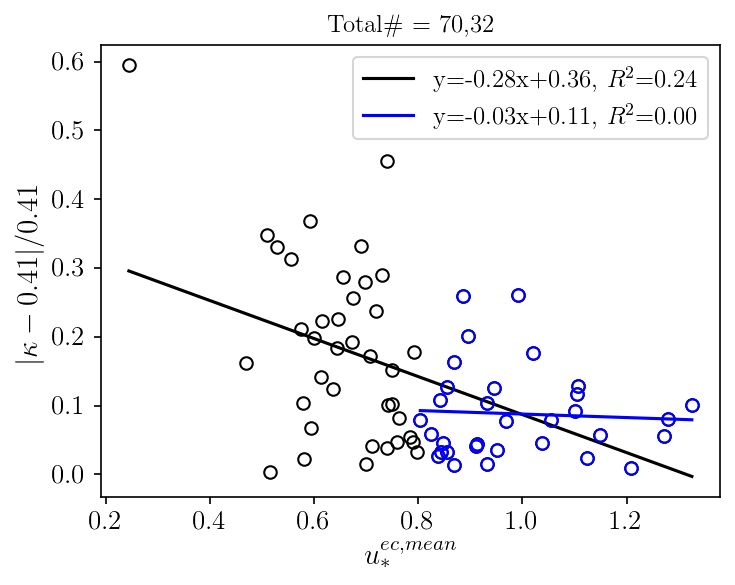

In [19]:
y_temp = abs(kappa_m2_ec_mean-0.41)/0.41
msk = r2_m2>0.85
msk1 = np.logical_and(msk,u_star_mean>0.8)
fig = plt.figure(figsize=(5,4), dpi=150,tight_layout=True)
ax3 = fig.add_subplot(111)
plt.plot(u_star_mean[msk],y_temp[msk],'o',color = 'k',markerfacecolor='none')
plt.xlabel(r'$u_*^{ec,mean}$', fontsize=font_size)
plt.ylabel(r'$|\kappa-0.41|/0.41$', fontsize=font_size)
# linear regression
slope, intercept,r,_,_ = stats.linregress(u_star_mean[msk], y_temp[msk])
x = np.sort(u_star_mean[msk])
line = slope*x+intercept
plt.plot(x, line, 'k', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
ax3.plot(u_star_mean[msk1],y_temp[msk1],'o',color = 'blue',markerfacecolor='none')
slope, intercept,r,_,_ = stats.linregress(u_star_mean[msk1],y_temp[msk1])
x = np.sort(u_star_mean[msk1])
line = slope*x+intercept
ax3.plot(x, line, 'blue', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
ax3.legend(fontsize=12)
ax3.title.set_text('Total\# = {:},{:}'.format(len(temp_stability[msk]),len(temp_stability[msk1])))
# plt.savefig(PLOT_DIRECTORY + 'u_star_mean_abs_kappa.jpg', dpi=200)

## kappa versus z/L ##

In [ ]:
y_temp = abs(kappa_m2_ec_mean-0.41)/0.41
msk = r2_m2>0.85
msk1 = np.logical_and(msk,u_star_mean>0.8)
fig = plt.figure(figsize=(5,4), dpi=150,tight_layout=True)
ax1 = fig.add_subplot(111)
plt.plot(temp_stability[msk],kappa_m2_ec_mean[msk],'o',color = 'k',markerfacecolor='none')
plt.axvline(x=0, color='grey', linestyle='--', linewidth=1)
plt.axhline(y=0.41, color='k', linestyle='--', linewidth=1)
plt.xlabel(r'\rm $<z>/L$', fontsize=font_size)
plt.ylabel(r'$\kappa$', fontsize=font_size)
plt.xlim(-0.08,0.08)
# linear regression
slope, intercept,r,_,_ = stats.linregress(temp_stability[msk], kappa_m2_ec_mean[msk])
x = np.sort(temp_stability[msk])
line = slope*x+intercept
plt.plot(x, line, 'k', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))

ax1.plot(temp_stability[msk1],kappa_m2_ec_mean[msk1],'o',color = 'blue',markerfacecolor='none')
slope, intercept,r,_,_ = stats.linregress(temp_stability[msk1],kappa_m2_ec_mean[msk1])
x = np.sort(temp_stability[msk1])
line = slope*x+intercept
ax1.plot(x, line, 'blue', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
ax1.legend(fontsize=12)
ax1.title.set_text('Total\# = {:},{:}'.format(len(temp_stability[msk]),len(temp_stability[msk1])))
plt.savefig(PLOT_DIRECTORY + 'zol_kappa.jpg', dpi=200)

## Kappa vs Z/L and u*,mean ##

In [ ]:
y_temp = abs(kappa_m2_ec_mean-0.4)/0.4
# y_temp  = kappa_m2_ec_mean
msk = r2_m2>0.85
# y_msk = y_temp<=np.nanmax(y_temp)
# y_plus = y_temp[y_msk]

fig = plt.figure(figsize=(14,8), dpi=150,tight_layout=True)
ax1 = fig.add_subplot(231) 
plt.plot(temp_stability[msk],kappa_m2_ec_mean[msk],'o',color = 'k',markerfacecolor='none')
plt.axvline(x=0, color='grey', linestyle='--', linewidth=1)
plt.axhline(y=0.4, color='k', linestyle='--', linewidth=1)
plt.xlabel(r'\rm $<z>/L$', fontsize=font_size)
plt.ylabel(r'$\kappa$', fontsize=font_size)
plt.xlim(-0.08,0.08)
# linear regression
slope, intercept,r,_,_ = stats.linregress(temp_stability[msk], kappa_m2_ec_mean[msk])
x = np.sort(temp_stability[msk])
line = slope*x+intercept
plt.plot(x, line, 'k', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
# plt.legend(fontsize=12)
# plt.title(r'Total\# = {:}'.format(len(y_temp[msk])))

ax2 = fig.add_subplot(232) 
plt.plot(u_star_dif_mean[msk],y_temp[msk],'o',color = 'k',markerfacecolor='none')
plt.xlabel(r'$[(u_*^{ec}-u_*^{ec,mean})/u_*^{ec,mean}]_{max}$', fontsize=font_size)
plt.ylabel(r'$|\kappa-0.4|/0.4$', fontsize=font_size)
# linear regression
slope, intercept,r,_,_ = stats.linregress(u_star_dif_mean[msk], y_temp[msk])
x = np.sort(u_star_dif_mean[msk])
line = slope*x+intercept
plt.plot(x, line, 'k', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
# plt.legend(fontsize=12)
# plt.title(r'Total\# = {:}'.format(len(y_temp[msk])))

ax3 = fig.add_subplot(233) 
plt.plot(u_star_mean[msk],y_temp[msk],'o',color = 'k',markerfacecolor='none')
plt.xlabel(r'$u_*^{ec,mean}$', fontsize=font_size)
plt.ylabel(r'$|\kappa-0.4|/0.4$', fontsize=font_size)
# linear regression
slope, intercept,r,_,_ = stats.linregress(u_star_mean[msk], y_temp[msk])
x = np.sort(u_star_mean[msk])
line = slope*x+intercept
plt.plot(x, line, 'k', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
# plt.legend(fontsize=12)
# plt.title(r'Total\# = {:}'.format(len(y_temp[msk])))

ax4 = fig.add_subplot(234) 
plt.plot(abs(temp_stability[msk]),u_star_dif_mean[msk],'o',color = 'k',markerfacecolor='none')
plt.xlabel(r'\rm $|<z>/L|$', fontsize=font_size)
plt.ylabel(r'$[(u_*^{ec}-u_*^{ec,mean})/u_*^{ec,mean}]_{max}$', fontsize=font_size)
# plt.xlim(-0.08,0.08)
# linear regression
slope, intercept,r,_,_ = stats.linregress(abs(temp_stability[msk]), u_star_dif_mean[msk])
x = np.sort(abs(temp_stability[msk]))
line = slope*x+intercept
plt.plot(x, line, 'k', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
# plt.legend(fontsize=12)
# plt.title(r'Total\# = {:}'.format(len(u_star_dif_mean[msk])))

ax5 = fig.add_subplot(235) 
plt.plot(u_star_dif_mean[msk],u_star_mean[msk],'o',color = 'k',markerfacecolor='none')
plt.xlabel(r'$[(u_*^{ec}-u_*^{ec,mean})/u_*^{ec,mean}]_{max}$', fontsize=font_size)
plt.ylabel(r'$u_*^{ec,mean}$', fontsize=font_size)
# linear regression
slope, intercept,r,_,_ = stats.linregress(u_star_dif_mean[msk], u_star_mean[msk])
x = np.sort(u_star_dif_mean[msk])
line = slope*x+intercept
plt.plot(x, line, 'k', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
# plt.legend(fontsize=12)
# plt.title(r'Total\# = {:}'.format(len(u_star_mean[msk])))
plt.axhline(y=0.8, color='grey', linestyle='--', linewidth=1)

ax6 = fig.add_subplot(236) 
plt.plot(u_star_mean[msk],abs(temp_stability[msk]),'o',color = 'k',markerfacecolor='none')
plt.xlabel(r'$u_*^{ec,mean}$', fontsize=font_size)
plt.ylabel(r'\rm $|<z>/L|$', fontsize=font_size)
# linear regression
slope, intercept,r,_,_ = stats.linregress(u_star_mean[msk], abs(temp_stability[msk]))
x = np.sort(u_star_mean[msk])
line = slope*x+intercept
plt.plot(x, line, 'k', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
# plt.legend(fontsize=12)
# plt.title(r'Total\# = {:}'.format(len(temp_stability[msk])))
plt.axvline(x=0.8, color='grey', linestyle='--', linewidth=1)

msk1 = np.logical_and(msk,u_star_mean>0.8)
ax1.plot(temp_stability[msk1],kappa_m2_ec_mean[msk1],'o',color = 'blue',markerfacecolor='none')
slope, intercept,r,_,_ = stats.linregress(temp_stability[msk1],kappa_m2_ec_mean[msk1])
x = np.sort(temp_stability[msk1])
line = slope*x+intercept
ax1.plot(x, line, 'blue', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
ax1.legend(fontsize=12)
ax1.title.set_text('Total\# = {:},{:}'.format(len(temp_stability[msk]),len(temp_stability[msk1])))

slope, intercept,r,_,_ = stats.linregress(abs(temp_stability[msk1]), u_star_dif_mean[msk1])
x = np.sort(abs(temp_stability[msk1]))
line = slope*x+intercept
ax4.plot(x, line, 'blue', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
ax4.legend(fontsize=12)

ax2.plot(u_star_dif_mean[msk1],y_temp[msk1],'o',color = 'blue',markerfacecolor='none')
slope, intercept,r,_,_ = stats.linregress(u_star_dif_mean[msk1],y_temp[msk1])
x = np.sort(u_star_dif_mean[msk1])
line = slope*x+intercept
ax2.plot(x, line, 'blue', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
ax2.legend(fontsize=12)
# ax2.title.set_text('Total\# = {:},{:}'.format(len(y_temp[msk]),len(y_temp[msk1])))

slope, intercept,r,_,_ = stats.linregress(u_star_dif_mean[msk1], u_star_mean[msk1])
x = np.sort(u_star_dif_mean[msk1])
line = slope*x+intercept
ax5.plot(x, line, 'blue', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
ax5.legend(fontsize=12)

ax3.plot(u_star_mean[msk1],y_temp[msk1],'o',color = 'blue',markerfacecolor='none')
slope, intercept,r,_,_ = stats.linregress(u_star_mean[msk1],y_temp[msk1])
x = np.sort(u_star_mean[msk1])
line = slope*x+intercept
ax3.plot(x, line, 'blue', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
ax3.legend(fontsize=12)
# ax3.title.set_text('Total\# = {:},{:}'.format(len(y_temp[msk]),len(y_temp[msk1])))

slope, intercept,r,_,_ = stats.linregress(u_star_mean[msk1], abs(temp_stability[msk1]))
x = np.sort(u_star_mean[msk1])
line = slope*x+intercept
ax6.plot(x, line, 'blue', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
ax6.legend(fontsize=12)

plt.savefig(PLOT_DIRECTORY + 'k_zol_u_star_ec_mean_vert_dev.jpg', dpi=200)

## kap vs stability ##

In [ ]:
fig = plt.figure(figsize=(10,4), dpi=150,tight_layout=True)
ax1 = fig.add_subplot(121) 
plt.plot(temp_stability[msk],y_temp[msk],'o',color = 'k',markerfacecolor='none')
plt.axvline(x=0, color='grey', linestyle='--', linewidth=1)
# plt.axhline(y=y_mean, color='grey', linestyle='--', linewidth=1)
plt.xlabel(r'\rm $<z>/L$', fontsize=font_size)
plt.ylabel(r'$\kappa$', fontsize=font_size)
plt.xlim(-0.08,0.08)
# linear regression
slope, intercept,r,_,_ = stats.linregress(temp_stability[msk], y_temp[msk])
x = np.sort(temp_stability[msk])
line = slope*x+intercept
plt.plot(x, line, 'r', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.legend(fontsize=12)
plt.title(r'Total\# = {:}'.format(len(y_temp[msk])))

## kappa vs IST,wspd,wdir ##

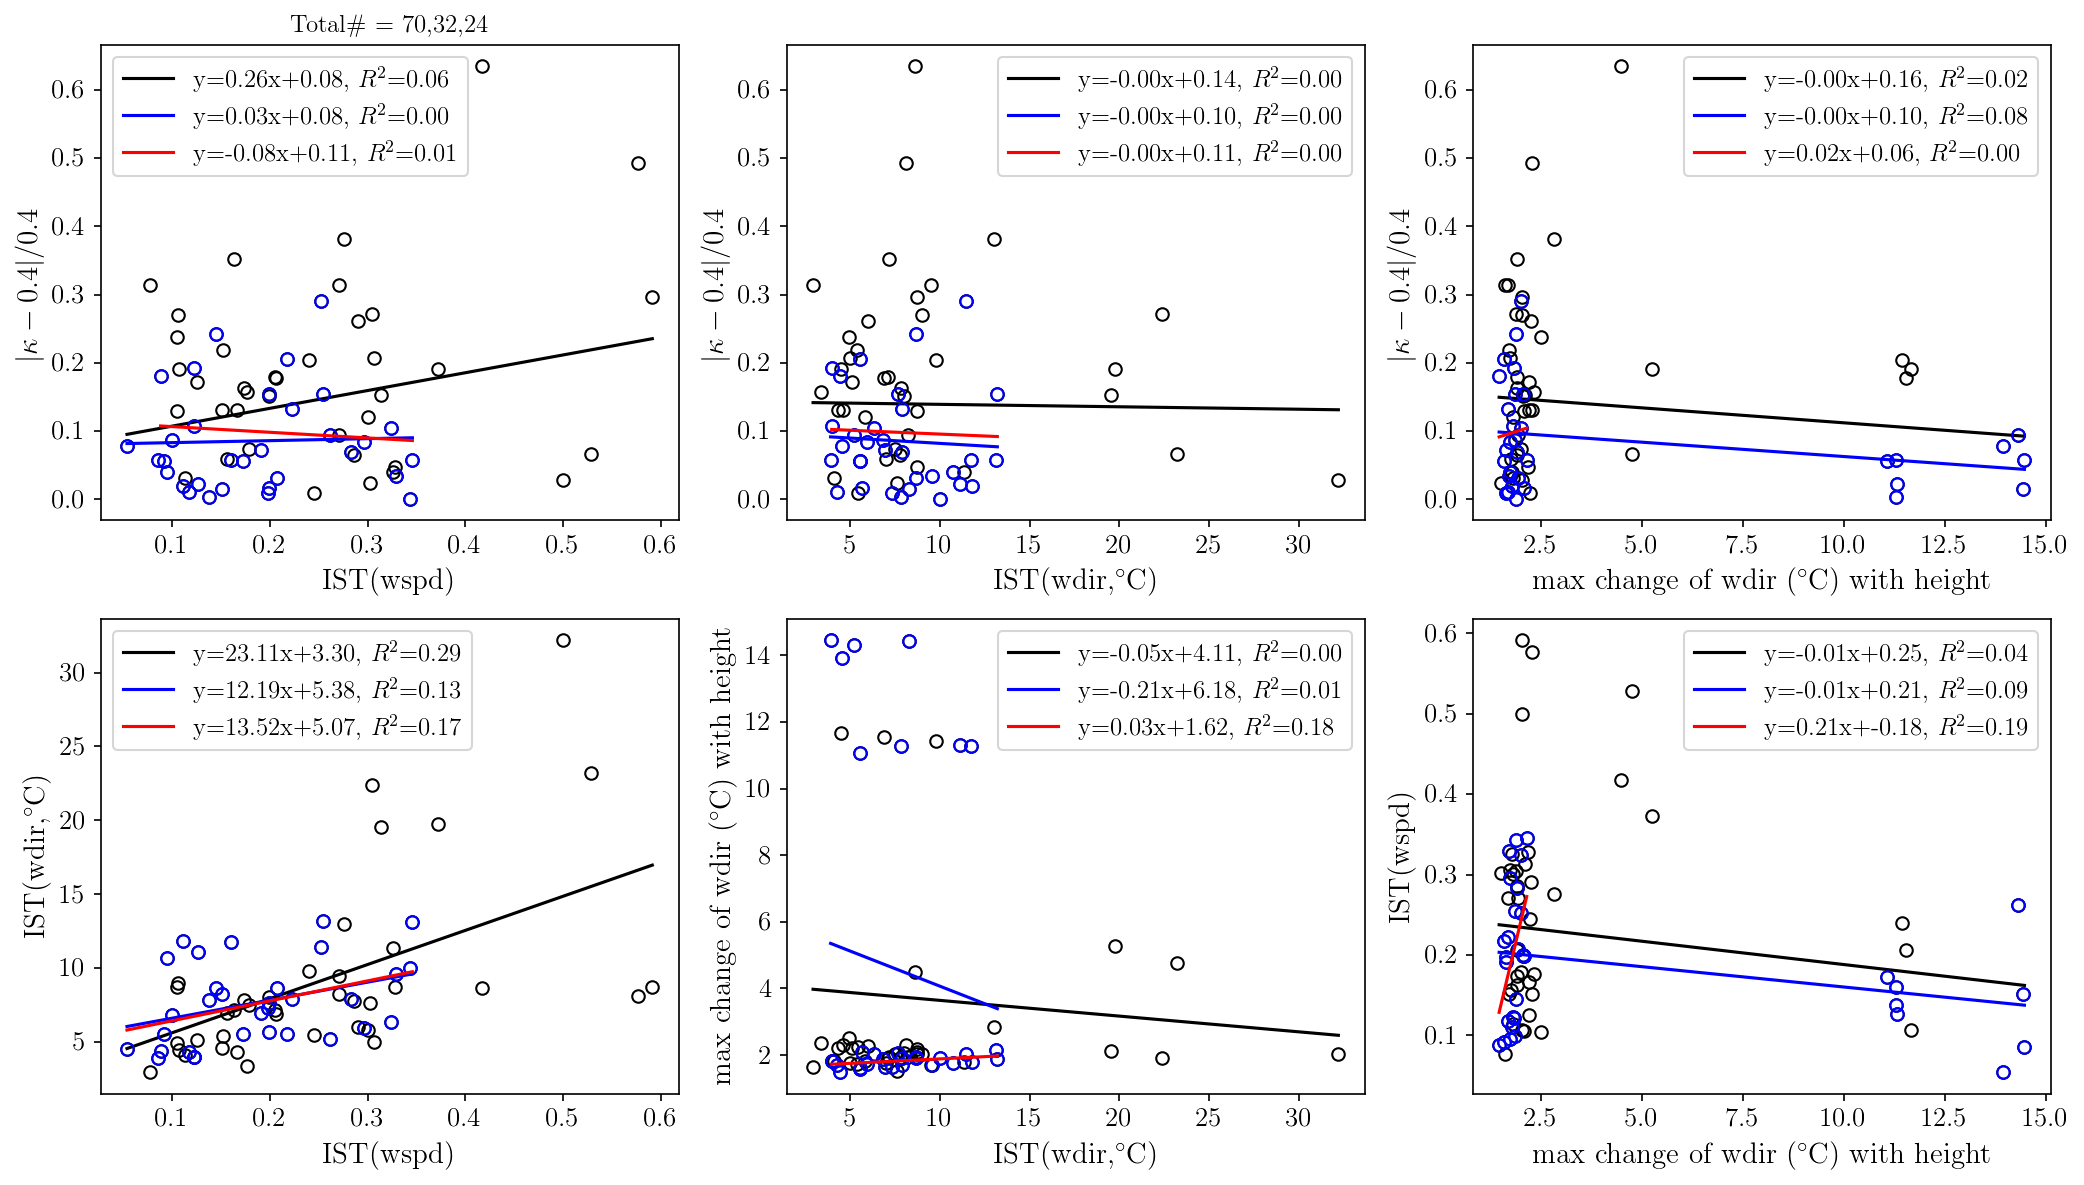

In [51]:
y_temp = abs(kappa_m2_ec_mean-0.4)/0.4
# y_temp = kappa_m2_ec_mean
msk = r2_m2>0.85
# msk = r2_m2>0
ist = np.nanmax(ist_before, axis=1)
fig = plt.figure(figsize=(14,8), dpi=150,tight_layout=True)

ax1 = fig.add_subplot(231)
plt.plot(ist[msk],y_temp[msk],'o',color = 'k',markerfacecolor='none')
plt.xlabel(r'IST(wspd)', fontsize=font_size)
plt.ylabel(r'$|\kappa-0.4|/0.4$', fontsize=font_size)
# linear regression
slope, intercept,r,_,_ = stats.linregress(ist[msk],y_temp[msk])
x = np.sort(ist[msk])
line = slope*x+intercept
plt.plot(x, line, 'k', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.legend(fontsize=12)
# plt.title(r'Total\# = {:}'.format(len(y_temp[msk])))

ax2 = fig.add_subplot(232)
x_temp2 = np.nanmax(wind_diff_max_neutral, axis=1)
plt.plot(x_temp2[msk],y_temp[msk],'o',color = 'k',markerfacecolor='none')
plt.xlabel(r'IST(wdir,$^\circ$C)', fontsize=font_size)
plt.ylabel(r'$|\kappa-0.4|/0.4$', fontsize=font_size)
# linear regression
slope, intercept,r,_,_ = stats.linregress(x_temp2[msk], y_temp[msk])
x = np.sort(x_temp2[msk])
line = slope*x+intercept
plt.plot(x, line, 'k', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.legend(fontsize=12)
# plt.title(r'Total\# = {:}'.format(len(y_temp[msk])))

ax3 = fig.add_subplot(233)
x_temp3 = np.nanmax(abs(np.diff(wdir_neutral[:,list_sel_m2],axis=1)),axis=1)
plt.plot(x_temp3[msk],y_temp[msk],'o',color = 'k',markerfacecolor='none')
plt.xlabel(r'max change of wdir ($^\circ$C) with height', fontsize=font_size)
plt.ylabel(r'$|\kappa-0.4|/0.4$', fontsize=font_size)
# linear regression
slope, intercept,r,_,_ = stats.linregress(x_temp3[msk], y_temp[msk])
x = np.sort(x_temp3[msk])
line = slope*x+intercept
plt.plot(x, line, 'k', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.legend(fontsize=12)
# plt.title(r'Total\# = {:}'.format(len(y_temp[msk])))

# msk1 = np.logical_and(msk,x_temp<4)
# msk0 = np.logical_and(msk,x_temp>4)
# ax1.plot(ist[msk0],y_temp[msk0],'o',color = 'grey',markerfacecolor='none')
# ax2.plot(x_temp2[msk0],y_temp[msk0],'o',color = 'grey',markerfacecolor='none')
# ax3.plot(x_temp3[msk0],y_temp[msk0],'o',color = 'grey',markerfacecolor='none')

ax4 = fig.add_subplot(234)
plt.plot(ist[msk],x_temp2[msk],'o',color = 'k',markerfacecolor='none')
plt.xlabel(r'IST(wspd)', fontsize=font_size)
plt.ylabel(r'IST(wdir,$^\circ$C)', fontsize=font_size)
# linear regression
slope, intercept,r,_,_ = stats.linregress(ist[msk],x_temp2[msk])
x = np.sort(ist[msk])
line = slope*x+intercept
plt.plot(x, line, 'k', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.legend(fontsize=12)
# plt.title(r'Total\# = {:}'.format(len(x_temp2[msk])))

ax5 = fig.add_subplot(235)
plt.plot(x_temp2[msk],x_temp3[msk],'o',color = 'k',markerfacecolor='none')
plt.xlabel(r'IST(wdir,$^\circ$C)', fontsize=font_size)
plt.ylabel(r'max change of wdir ($^\circ$C) with height', fontsize=font_size)
# linear regression
slope, intercept,r,_,_ = stats.linregress(x_temp2[msk],x_temp3[msk])
x = np.sort(x_temp2[msk])
line = slope*x+intercept
plt.plot(x, line, 'k', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.legend(fontsize=12)
# plt.title(r'Total\# = {:}'.format(len(x_temp3[msk])))

ax6 = fig.add_subplot(236)
plt.plot(x_temp3[msk],ist[msk],'o',color = 'k',markerfacecolor='none')
plt.xlabel(r'max change of wdir ($^\circ$C) with height', fontsize=font_size)
plt.ylabel(r'IST(wspd)', fontsize=font_size)
# linear regression
slope, intercept,r,_,_ = stats.linregress(x_temp3[msk],ist[msk])
x = np.sort(x_temp3[msk])
line = slope*x+intercept
plt.plot(x, line, 'k', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.legend(fontsize=12)
# plt.title(r'Total\# = {:}'.format(len(x_temp3[msk])))

msk1 = np.logical_and(msk,u_star_mean>0.8)

ax1.plot(ist[msk1],y_temp[msk1],'o',color = 'blue',markerfacecolor='none')
slope, intercept,r,_,_ = stats.linregress(ist[msk1],y_temp[msk1])
x = np.sort(ist[msk1])
line = slope*x+intercept
ax1.plot(x, line, 'blue', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))

ax4.plot(ist[msk1],x_temp2[msk1],'o',color = 'blue',markerfacecolor='none')
slope, intercept,r,_,_ = stats.linregress(ist[msk1],x_temp2[msk1])
x = np.sort(ist[msk1])
line = slope*x+intercept
ax4.plot(x, line, 'blue', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))

ax2.plot(x_temp2[msk1],y_temp[msk1],'o',color = 'blue',markerfacecolor='none')
slope, intercept,r,_,_ = stats.linregress(x_temp2[msk1],y_temp[msk1])
x = np.sort(x_temp2[msk1])
line = slope*x+intercept
ax2.plot(x, line, 'blue', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))

ax5.plot(x_temp2[msk1],x_temp3[msk1],'o',color = 'blue',markerfacecolor='none')
slope, intercept,r,_,_ = stats.linregress(x_temp2[msk1],x_temp3[msk1])
x = np.sort(x_temp2[msk1])
line = slope*x+intercept
ax5.plot(x, line, 'blue', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))

ax3.plot(x_temp3[msk1],y_temp[msk1],'o',color = 'blue',markerfacecolor='none')
slope, intercept,r,_,_ = stats.linregress(x_temp3[msk1],y_temp[msk1])
x = np.sort(x_temp3[msk1])
line = slope*x+intercept
ax3.plot(x, line, 'blue', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))

ax6.plot(x_temp3[msk1],ist[msk1],'o',color = 'blue',markerfacecolor='none')
slope, intercept,r,_,_ = stats.linregress(x_temp3[msk1],ist[msk1])
x = np.sort(x_temp3[msk1])
line = slope*x+intercept
ax6.plot(x, line, 'blue', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))


msk2 = np.logical_and(msk1,x_temp3<4)
# ax1.plot(ist[msk2],y_temp[msk2],'o',color = 'red',markerfacecolor='none')
slope, intercept,r,_,_ = stats.linregress(ist[msk2],y_temp[msk2])
x = np.sort(ist[msk2])
line = slope*x+intercept
ax1.plot(x, line, 'red', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
ax1.legend(fontsize=12)
ax1.title.set_text('Total\# = {:},{:},{:}'.format(len(x_temp3[msk]),len(x_temp3[msk1]),len(x_temp3[msk2])))

slope, intercept,r,_,_ = stats.linregress(ist[msk2],x_temp2[msk2])
x = np.sort(ist[msk1])
line = slope*x+intercept
ax4.plot(x, line, 'red', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
ax4.legend(fontsize=12)

# ax2.plot(x_temp2[msk2],y_temp[msk2],'o',color = 'red',markerfacecolor='none')
slope, intercept,r,_,_ = stats.linregress(x_temp2[msk2],y_temp[msk2])
x = np.sort(x_temp2[msk2])
line = slope*x+intercept
ax2.plot(x, line, 'red', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
ax2.legend(fontsize=12)

slope, intercept,r,_,_ = stats.linregress(x_temp2[msk2],x_temp3[msk2])
x = np.sort(x_temp2[msk2])
line = slope*x+intercept
ax5.plot(x, line, 'red', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
ax5.legend(fontsize=12)

# ax3.plot(x_temp3[msk2],y_temp[msk2],'o',color = 'red',markerfacecolor='none')
slope, intercept,r,_,_ = stats.linregress(x_temp3[msk2],y_temp[msk2])
x = np.sort(x_temp3[msk2])
line = slope*x+intercept
ax3.plot(x, line, 'red', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
ax3.legend(fontsize=12)

slope, intercept,r,_,_ = stats.linregress(x_temp3[msk2],ist[msk2])
x = np.sort(x_temp3[msk2])
line = slope*x+intercept
ax6.plot(x, line, 'red', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
ax6.legend(fontsize=12)


# plt.savefig(PLOT_DIRECTORY + 'k_ist_wspd_wdir.jpg', dpi=200)

## Kappa vs change of u* and wdir with hgt ##

In [ ]:
y_temp = abs(kappa_m2_ec_mean-0.4)/0.4
# y_temp = kappa_m2_ec_mean
msk = r2_m2>0.9

fig = plt.figure(figsize=(10,4), dpi=150,tight_layout=True)
ax1 = fig.add_subplot(121) 
x_temp = np.nanmax(abs(np.diff(u_star_neutral[:,list_sel_m2],axis=1)),axis=1)
plt.plot(x_temp[msk],y_temp[msk],'o',color = 'k',markerfacecolor='none')
plt.xlabel(r'max change of $u_*^{ec}$ (m/s) with height', fontsize=font_size)
plt.ylabel(r'$|\kappa-0.4|/0.4$', fontsize=font_size)
# linear regression
slope, intercept,r,_,_ = stats.linregress(x_temp[msk],y_temp[msk])
x = np.sort(x_temp[msk])
line = slope*x+intercept
plt.plot(x, line, 'r', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.legend(fontsize=12)
plt.title(r'Total\# = {:}'.format(len(y_temp[msk])))

ax2 = fig.add_subplot(122)
x_temp = np.nanmax(abs(np.diff(wdir_neutral[:,list_sel_m2],axis=1)),axis=1)
plt.plot(x_temp[msk],y_temp[msk],'o',color = 'k',markerfacecolor='none')
plt.xlabel(r'max change of wdir ($^\circ$C) with height', fontsize=font_size)
plt.ylabel(r'$|\kappa-0.4|/0.4$', fontsize=font_size)
# linear regression
slope, intercept,r,_,_ = stats.linregress(x_temp[msk], y_temp[msk])
x = np.sort(x_temp[msk])
line = slope*x+intercept
plt.plot(x, line, 'r', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.legend(fontsize=12)
plt.title(r'Total\# = {:}'.format(len(y_temp[msk])))

plt.savefig(PLOT_DIRECTORY + 'k_u_star_wdir_hgt.jpg', dpi=200)

In [ ]:
x_temp = np.nanmax(abs(np.diff(wdir_neutral[:,list_sel_m2],axis=1)),axis=1)
msk = np.logical_and(r2_m2>0.9,x_temp<4)
fig = plt.figure(figsize=(5,4), dpi=150,tight_layout=True)
plt.plot(x_temp[msk],y_temp[msk],'o',color = 'k',markerfacecolor='none')
plt.xlabel(r'max change of wdir ($^\circ$C) with height', fontsize=font_size)
plt.ylabel(r'$|\kappa-0.4|/0.4$', fontsize=font_size)
# linear regression
slope, intercept,r,_,_ = stats.linregress(x_temp[msk], y_temp[msk])
x = np.sort(x_temp[msk])
line = slope*x+intercept
plt.plot(x, line, 'r', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.legend(fontsize=12)
plt.title(r'Total\# = {:}'.format(len(y_temp[msk])))
plt.savefig(PLOT_DIRECTORY + 'k_wdir_hgt.jpg', dpi=200)

## IST VS u_star_dif ##

In [ ]:
fig = plt.figure(figsize=(5,4), dpi=150,tight_layout=True)
plt.plot(ist_before[y_msk],u_star_m2_dif[y_msk],'o',color = 'k',markerfacecolor='none')
slope, intercept,r,_,_ = stats.linregress(ist[y_msk],u_star_m2_dif[y_msk])
x = np.sort(ist[y_msk])
line = slope*x+intercept
plt.plot(x, line, 'r', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.legend(fontsize=12)
plt.xlabel(r'IST', fontsize=font_size)
plt.ylabel(r'$(u_*^{ec,max}-u_*^{ec,min})/u_*^{ec,min}$', fontsize=font_size)

## Kappa vs wind angle ##

In [ ]:
fig = plt.figure(figsize=(8,4), dpi=150,tight_layout=True)
ax1 = fig.add_subplot(121)
y_temp = abs(kappa_m2-0.4)/0.4
x_msk = np.logical_and(wind_ang_neutral>180,y_temp<1)
plt.plot(wind_ang_neutral[x_msk],y_temp[x_msk],'o',color = 'k',markerfacecolor='none')
# plt.axvline(x=0, color='grey', linestyle='--', linewidth=1)
# plt.axhline(y=0.4, color='grey', linestyle='--', linewidth=1)
plt.xlabel(r'wind direction (C)', fontsize=font_size)
plt.ylabel(r'$\kappa^+$', fontsize=font_size)
# linear regression
slope, intercept,r,_,_ = stats.linregress(wind_ang_neutral[x_msk], y_temp[x_msk])
x = np.sort(wind_ang_neutral[x_msk])
line = slope*x+intercept
plt.plot(x, line, 'r', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.legend(fontsize=12)

ax2 = fig.add_subplot(122)
x_msk = np.logical_and(wind_ang_neutral<180,y_temp<1)
plt.plot(wind_ang_neutral[x_msk],y_temp[x_msk],'o',color = 'k',markerfacecolor='none')
# plt.axvline(x=0, color='grey', linestyle='--', linewidth=1)
# plt.axhline(y=0.4, color='grey', linestyle='--', linewidth=1)
plt.xlabel(r'wind direction (C)', fontsize=font_size)
plt.ylabel(r'$\kappa^+$', fontsize=font_size)
# linear regression
slope, intercept,r,_,_ = stats.linregress(wind_ang_neutral[x_msk], y_temp[x_msk])
x = np.sort(wind_ang_neutral[x_msk])
line = slope*x+intercept
plt.plot(x, line, 'r', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.legend(fontsize=12)

## neutral case distribution ##

In [ ]:
plt.figure(figsize=(6, 4), dpi=150)
_ = plt.hist(np.array(neutral_case)[:,1], color = "skyblue",edgecolor="steelblue", bins=20)  # arguments are passed to np.histogram
# plt.title(r"\rm Histogram of hours", fontsize = 16)
plt.text(1,10,r'Total\# = {:}'.format(len(neutral_case)), fontsize = 16)
plt.xlabel(r'\rm Occurrence of the neutral condition', fontsize = font_size)
plt.ylabel(r'\rm Histogram', fontsize = font_size)
# plt.savefig(PLOT_DIRECTORY + 'neutral_hour_hist.jpg', dpi=200)

## kappa distribution ##

In [ ]:
fig = plt.figure(figsize=(10,4), dpi=200,tight_layout=True)
ax1 = fig.add_subplot(121)
_ = plt.hist(kappa_m2_ec_mean[msk], color = "skyblue",edgecolor="steelblue", bins=30, density=True)
plt.xlabel(r'$\kappa(\it u_*^{ec,mean})$ before', fontsize=font_size)
plt.ylabel(r'\rm Histogram', fontsize = font_size)
plt.title("mean = {:.2f}, $\sigma$ = {:.2f}".format(np.nanmean(kappa_m2_ec_mean[msk]),np.nanstd(kappa_m2_ec_mean[msk])))
plt.xlim(0.2,0.8)

ax2 = fig.add_subplot(122)
msk = r2_m2>0.85
msk1 = np.logical_and(msk,u_star_mean>0.8)
_ = plt.hist(kappa_m2_ec_mean[msk1], color = "skyblue",edgecolor="steelblue", bins=30, density=True)
plt.xlabel(r'$\kappa(\it u_*^{ec,mean})$ after', fontsize=font_size)
plt.ylabel(r'\rm Histogram', fontsize = font_size)
plt.title("mean = {:.2f}, $\sigma$ = {:.2f}".format(np.nanmean(kappa_m2_ec_mean[msk1]),np.nanstd(kappa_m2_ec_mean[msk1])))
plt.xlim(0.2,0.6)

plt.savefig(PLOT_DIRECTORY + 'kappa_ustar_mean_distri.jpg')

## kappa_ec_mean vs kappa_ec_linear ##

In [ ]:
plt.figure(figsize=(5, 4), dpi=150,tight_layout=True)
plt.plot(kappa_m2_ec_mean,kappa_m2,'o',color = 'grey',markerfacecolor='none')
# plt.xlim((0,1.5))
# plt.ylim((0,1.5))
plt.gca().axline((1, 1), slope=1, color='black', linestyle='solid', linewidth=1)
plt.xlabel(r'$\kappa(\it u_*^{ec,mean})$',fontsize=font_size)
plt.ylabel(r'$\kappa(\it u_*^{ec,linear})$',fontsize=font_size)
plt.savefig(PLOT_DIRECTORY + 'kappa_ec_mean_linear.jpg', dpi=200)

## kappa stability corrected value ##

In [ ]:
fig = plt.figure(figsize=(8,4), dpi=200,tight_layout=True)
ax1 = fig.add_subplot(121)
_ = plt.hist(kappa_m2, color = "skyblue",edgecolor="steelblue", bins=20, range=(0.2,0.6), density=True)
plt.xlabel(r'$\kappa$', fontsize=font_size)
plt.ylabel(r'\rm Histogram', fontsize = font_size)
ax1.title.set_text("original data, median = "+str(round(ndimage.median(kappa_m2),2)))
plt.xlim(0.2,0.6)

ax2 = fig.add_subplot(122)
_ = plt.hist(kappa_m2_stability_corrected, color = "skyblue",edgecolor="steelblue", bins=20, range=(0.2,0.6), density=True)
plt.xlabel(r'$\kappa$', fontsize=font_size)
plt.ylabel(r'\rm Histogram', fontsize = font_size)
ax2.title.set_text("stability corrected, median = "+str(round(ndimage.median(kappa_m2_stability_corrected),2)))
plt.xlim(0.2,0.6)

plt.savefig(PLOT_DIRECTORY + 'kappa_values.jpg')

## comparison of u_star across vertical levels ##

In [ ]:
fig = plt.figure(figsize=(6, 5), dpi=150,tight_layout=True)
# Filter data using np.isnan
mask = ~np.isnan(u_star_dev)
filtered_data = [d[m] for d, m in zip(u_star_dev.T, mask.T)]
filtered_data = np.array(filtered_data)
plt.boxplot(filtered_data[[0,1,2,3,4,5,6,7,8,9,10,11]], vert=False)
plt.xlim(-0.5,0.5)
# plot reference lines
plt.axvline(x=0, color='grey', linestyle='--', linewidth=1)
plt.axvline(x=0.25, color='grey', linestyle='--', linewidth=1)
plt.axvline(x=-0.25, color='grey', linestyle='--', linewidth=1)
plt.axhspan(5.5, 11.5, facecolor='blue', alpha=0.15)

# change xticks to be texts
labels = [item.get_text() for item in plt.gca().get_xticklabels()]
labels = [xtick_labels[i] for i in [0,1,2,3,4,5,6,7,8,9,10,11]]
plt.gca().set_yticklabels(labels)

plt.ylabel(r'\rm Height (m)', fontsize=font_size)
plt.xlabel(r'$\it (u_*^{ec}-u_*^{ec,mean})/u_*^{ec,mean}$', fontsize=font_size)

plt.savefig(PLOT_DIRECTORY + 'ustr_vertical_compare_box.jpg', dpi=200)

## comparison of u_star across two methods ##
### selected levels ###

In [ ]:
# plt.figure(figsize=(5, 5), dpi=150)
fig, ax = plt.subplots(figsize=(7, 4), dpi=150)
# Filter data using np.isnan
mask = ~np.isnan(u_star_m1_sel_dev)
filtered_data = [d[m] for d, m in zip(u_star_m1_sel_dev.T, mask.T)]
plt.ylim(-0.7,0.7)
plt.boxplot(filtered_data[5:11])

# plot reference lines
plt.axhline(y=0, color='grey', linestyle='--', linewidth=1)
plt.axhline(y=0.25, color='grey', linestyle='--', linewidth=1)
plt.axhline(y=-0.25, color='grey', linestyle='--', linewidth=1)

# change xticks to be texts
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = xtick_labels[5:11]
ax.set_xticklabels(labels)

plt.xlabel(r'\rm Level (m)', fontsize=font_size)
plt.ylabel(r'$\it (u_*^{ec}-u_*^{fit,sel})/u_*^{fit,sel}$', fontsize=font_size)
# plt.savefig(PLOT_DIRECTORY + 'ustr_compare_box_m1_sel_ec.jpg', dpi=200)

### all levels ###

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=150)
# Filter data using np.isnan
mask = ~np.isnan(u_star_m1_dev)
filtered_data = [d[m] for d, m in zip(u_star_m1_dev.T, mask.T)]
filtered_data = np.array(filtered_data)
plt.ylim(-0.7,0.7)
plt.boxplot(filtered_data[[0,1,2,3,4,5,6,7,8,9,10,11]])

# plot reference lines
plt.axhline(y=0, color='grey', linestyle='--', linewidth=1)
plt.axhline(y=0.25, color='grey', linestyle='--', linewidth=1)
plt.axhline(y=-0.25, color='grey', linestyle='--', linewidth=1)

# change xticks to be texts
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = [xtick_labels[i] for i in [0,1,2,3,4,5,6,7,8,9,10,11]]
ax.set_xticklabels(labels)

plt.xlabel(r'\rm Level (m)', fontsize=font_size)
plt.ylabel(r'$\it (u_*^{ec}-u_*^{fit,all})/u_*^{fit,all}$', fontsize=font_size)
# plt.savefig(PLOT_DIRECTORY + 'ustr_compare_box_m1_all_ec.jpg', dpi=200)

## Log wind profile for ustar mean ##

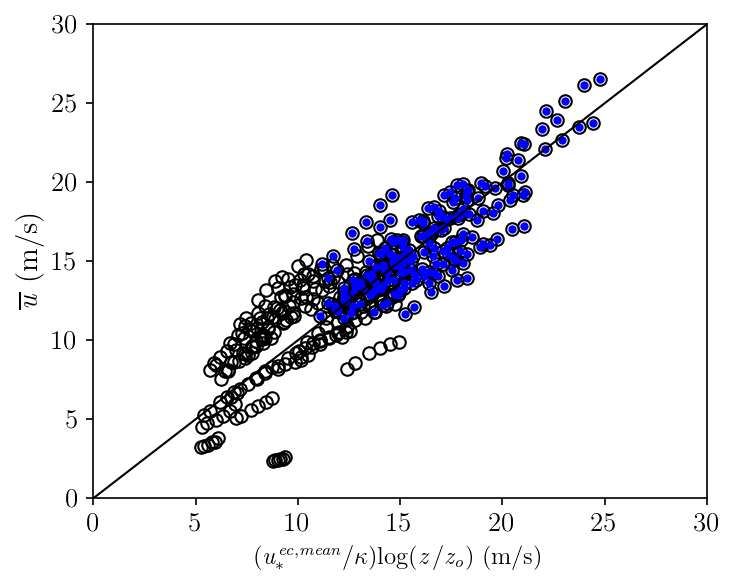

In [49]:
msk1 = u_star_mean>0.8
fig = plt.figure(figsize=(5,4), dpi=150,tight_layout=True)
ax1 = fig.add_subplot(111) 

plt.plot((u_star_mean/kappa*(np.log(z[list_sel_m2,None]/zo_m1_sel))),
         (u_avg_neutral.T)[list_sel_m2,:],'o',color = 'k',markerfacecolor='none')
plt.plot((u_star_mean/kappa*(np.log(z[list_sel_m2,None]/zo_m1_sel)))[:,msk1],
         (u_avg_neutral.T)[list_sel_m2,:][:,msk1],'.',color='blue')
# ax1.scatter(u_star_mean/kappa*(np.log(z[:,None]/zo_m1_sel)),u_avg_neutral.T, edgecolors='grey', facecolors='none')
# ax1.scatter((u_star_mean/kappa*(np.log(z[:,None]/zo_m1_sel)))[msk1],u_avg_neutral.T[msk1], edgecolors='grey', facecolors='none')
ax1.set_xlim((0,30))
ax1.set_ylim((0,30))
ax1.axline((1, 1), slope=1, color='black', linestyle='solid', linewidth=1)
ax1.set_xlabel(r'$(\it u_*^{ec,mean}/\kappa \rm)log(\it z/z_o\rm)$ (m/s)',fontsize=12)
ax1.set_ylabel(r'$\it \overline{u}$ (m/s)',fontsize=font_size)
plt.savefig(PLOT_DIRECTORY + 'MVP_u_star_mean.jpg', dpi=200)

## Log wind profile for both methods ##

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(8, 4), dpi=150,
                                       constrained_layout=True)
ax[0].scatter(u_star_m1_sel/kappa*(np.log(z[:,None]/zo_m1_sel)),u_avg_neutral.T, edgecolors='grey', facecolors='none')
ax[0].set_xlim((0,30))
ax[0].set_ylim((0,30))
# ax = plt.gca()
# x = np.linspace(*ax[0].get_ylim())
# ax[0].plot(x, x, color='black')
ax[0].axline((1, 1), slope=1, color='black', linestyle='solid', linewidth=1)
ax[0].set_xlabel(r'$(\it u_*^{fit,select}/\kappa_v \rm)log(\it z/z_o\rm)$',fontsize=12)
ax[0].set_ylabel(r'$\it \overline{u}$',fontsize=font_size)

ax[1].scatter(u_star_m2/kappa*(np.log(z[:,None]/zo_m1_sel)),u_avg_neutral.T, edgecolors='grey', facecolors='none')
ax[1].set_xlim((0,30))
ax[1].set_ylim((0,30))
ax[1].axline((1, 1), slope=1, color='black', linestyle='solid', linewidth=1)
ax[1].set_xlabel(r'$(\it u_*^{ec,select}/\kappa_v \rm)log(\it z/z_o\rm)$',fontsize=12)
ax[1].set_ylabel(r'$\it \overline{u}$',fontsize=font_size)
# plt.savefig(PLOT_DIRECTORY + 'all_runs_MVP_all_data.jpg', dpi=200)

## scatter plot between two methods ##
### u* fit vs u* mean ###

In [ ]:
plt.figure(figsize=(5, 4), dpi=150,tight_layout=True)
plt.plot(u_star_m1_sel,u_star_neutral[:,list_sel_m1],'o',color = 'grey',markerfacecolor='none')
plt.scatter(u_star_m1_sel,u_star_mean, edgecolors='k', facecolors='none',zorder=3)
plt.xlim((0,1.5))
plt.ylim((0,1.5))
plt.gca().axline((1, 1), slope=1, color='black', linestyle='solid', linewidth=1)
plt.xlabel(r'$\it u_{\tau}^{fit,sel},$ \rm method 1 (m/s)',fontsize=font_size)
plt.ylabel(r'$\it u_*^{ec}$ (m/s)',fontsize=font_size)
# plt.savefig(PLOT_DIRECTORY + 'ustr_scatter_m1_ec.jpg', dpi=200)

In [ ]:
plt.figure(figsize=(5, 4), dpi=150,tight_layout=True)
mask = ~np.isnan(u_star_neutral[:,list_sel_m1])
filtered_data = [d[m] for d, m in zip(u_star_neutral[:,list_sel_m1], mask)]
plt.boxplot(filtered_data, positions=u_star_m1_sel,widths=0.03,whis=(0,100))
plt.gca().set_xticks(np.linspace(0,1.5,7),labels=np.linspace(0,1.5,7), minor=False)
plt.xlim((0,1.5))
plt.ylim((0,1.5))
plt.gca().axline((1, 1), slope=1, color='black', linestyle='solid', linewidth=1)
plt.xlabel(r'$\it u_{\tau}^{fit,sel},$ \rm method 1 (m/s)',fontsize=font_size)
plt.ylabel(r'$\it u_*^{ec}$ (m/s)',fontsize=font_size)

### u*,fit vs u*,ec ###

In [ ]:
# plt.figure(figsize=(9, 4), dpi=150)
fig = plt.figure(figsize=(10,4), dpi=150,tight_layout=True)
ax1 = fig.add_subplot(121)
mask = ~np.isnan(u_star_neutral[:,list_sel_m1])
filtered_data = [d[m] for d, m in zip(u_star_neutral[:,list_sel_m1], mask)]
plt.boxplot(filtered_data, positions=u_star_m1_sel,widths=0.03,whis=(0,100))
ax1.set_xticks(np.linspace(0,1.5,7),labels=np.linspace(0,1.5,7), minor=False)
plt.xlim((0,1.5))
plt.ylim((0,1.5))
ax1.axline((1, 1), slope=1, color='grey', linestyle='solid', linewidth=1)
plt.xlabel(r'$\it u_{\tau}^{fit,sel},$ \rm method 1 (m/s)',fontsize=font_size)
plt.ylabel(r'$\it u_*^{ec}$ (m/s)',fontsize=font_size)


ax2 = fig.add_subplot(122)
_ = plt.hist(u_star_m1, color = "skyblue",edgecolor="steelblue", bins=20)  # arguments are passed to np.histogram
# plt.title(r"\rm Histogram of hours", fontsize = 16)
plt.title("mean = {:.2f}, $\sigma$ = {:.2f}".format(np.nanmean(u_star_m1),np.nanstd(u_star_m1)))
plt.xlabel(r'$\it u_{\tau}^{fit,sel},$ \rm method 1 (m/s)', fontsize = font_size)
plt.ylabel(r'\rm Histogram', fontsize = font_size)

plt.savefig(PLOT_DIRECTORY + 'u_star_m1_u_star_ec.jpg', dpi=200)

### u* distribution ###

In [ ]:
fig = plt.figure(figsize=(10,4), dpi=150,tight_layout=True)
ax1 = fig.add_subplot(121)
_ = plt.hist(u_star_mean, color = "skyblue",edgecolor="steelblue", bins=30)  # arguments are passed to np.histogram
# plt.title(r"\rm Histogram of hours", fontsize = 16)
plt.title("mean = {:.2f}, $\sigma$ = {:.2f}".format(np.nanmean(u_star_mean),np.nanstd(u_star_mean)))
plt.xlabel(r'$\it u_*^{ec,mean}$ (m/s)', fontsize = font_size)
plt.ylabel(r'\rm Histogram', fontsize = font_size)
plt.xlim(0,1.4)

ax2 = fig.add_subplot(122)
_ = plt.hist(u_star_fit, color = "skyblue",edgecolor="steelblue", bins=30)  # arguments are passed to np.histogram
# plt.title(r"\rm Histogram of hours", fontsize = 16)
plt.title("mean = {:.2f}, $\sigma$ = {:.2f}".format(np.nanmean(u_star_fit),np.nanstd(u_star_fit)))
plt.xlabel(r'$\it u_*^{ec,linear}$ (m/s)', fontsize = font_size)
plt.ylabel(r'\rm Histogram', fontsize = font_size)
plt.xlim(0,1.4)

plt.savefig(PLOT_DIRECTORY + 'u_star_hist.jpg', dpi=200)

### u* mean vs u* interp ###

In [ ]:
plt.figure(figsize=(4, 4), dpi=150,tight_layout=True)
plt.scatter(u_star_m2,u_star_fit, edgecolors='grey', facecolors='none')
plt.xlim((0,1.5))
plt.ylim((0,1.5))
plt.gca().axline((1, 1), slope=1, color='black', linestyle='solid', linewidth=1)
plt.xlabel(r'$\it u_*^{mean}$ (m/s)',fontsize=font_size)
plt.ylabel(r'$\it u_*^{interp}$ (m/s)',fontsize=font_size)

## Z0 momentum roughness length ##

In [ ]:
fig = plt.figure(figsize=(8,4), dpi=200,tight_layout=True)
ax1 = fig.add_subplot(121)
_ = plt.hist(zo_m1, color = "skyblue",edgecolor="steelblue", bins=20, range=(0,0.3), density=True)
plt.xlabel(r'$z_0$ (m)', fontsize=font_size)
plt.ylabel(r'\rm Histogram', fontsize = font_size)
ax1.title.set_text("mean = " + str(round(np.nanmean(zo_m1),2))+", std = "+str(round(np.nanstd(zo_m1),2)))
plt.xlim(0,0.3)
plt.ylim(0,30)

ax2 = fig.add_subplot(122)
_ = plt.hist(zo_m1_sel, color = "skyblue",edgecolor="steelblue", bins=20, range=(0,0.3), density=True)
plt.xlabel(r'$z_0^{sel}$ (m)', fontsize=font_size)
plt.ylabel(r'\rm Histogram', fontsize = font_size)
ax2.title.set_text("mean = " + str(round(np.nanmean(zo_m1_sel),2))+", std = "+str(round(np.nanstd(zo_m1_sel),2)))
plt.xlim(0,0.3)
plt.ylim(0,30)

# plt.savefig(PLOT_DIRECTORY + 'z0_values.jpg')